In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
!nvidia-smi

Fri Mar 17 14:45:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import tqdm as tqdm
import os
import traceback
import cv2
import glob
import os
import matplotlib.pyplot as plt
import torchvision
import time
from torch.utils.data import DataLoader, Dataset
from torch import nn
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pathlib

from skimage.io import imread
from torch.utils import data
from tqdm import tqdm


import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import copy
import random



In [ ]:
torch.cuda.empty_cache()

In [ ]:
!pip install torchmetrics
from torchmetrics.classification import BinaryJaccardIndex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 11.3 MB/s eta 0:00:00


In [ ]:
#Ovde treba ubaciti path za bazu


##Choosing device

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##Paths to images

In [ ]:
image_path = os.path.join('/content/MyDrive/MyDrive/kaggle_dataset/lung_segmentation/Lung Segmentation/CXR_png')
mask_path = os.path.join('/content/MyDrive/MyDrive/kaggle_dataset/lung_segmentation/Lung Segmentation/masks')
images = os.listdir(image_path)
masks = os.listdir(mask_path)
#images_val = os.listdir(image_path_val)
#masks_val = os.listdir(mask_path_val)
print(len(images))
print(len(masks))
# print(masks)

800
704


##Creating dir for saving model

In [ ]:
!mkdir /content/MyDrive/MyDrive/lung_segmentation_model

##Displaying image and mask from database

In [ ]:
img = cv2.imread(image_path +'/CHNCXR_0010_0.png')
mask = cv2.imread(mask_path + '/CHNCXR_0010_0_mask.png')
hor = np.concatenate((img, mask), axis=1)
cv2_imshow(hor)


##Function for saving model

In [ ]:
def save_model(epochs, model, optimizer, criterion, pretrained):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"/content/MyDrive/MyDrive/lung_segmentation_model/lung_model_pretrained_{pretrained}_epochs_{epochs}.pth")
    #/content/MyDrive/MyDrive/outputsNovi/model_pretrained_

##Defining the model

In [ ]:
class UNet(nn.Module):
    def __init__(self, input_size=(256,256,1)):
        super(UNet, self).__init__()

        self.input_size = input_size

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                  nn.ReLU())
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(512),
                                  nn.ReLU())

        self.up6 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(256),
                                  nn.ReLU())

        self.up7 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(128),
                                  nn.ReLU())

        self.up8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv8 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                  nn.ReLU())

        self.up9 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.conv9 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(32),
                                  nn.ReLU())

        self.conv10 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)

        conv5 = self.conv5(pool4)

        up6 = self.up6(conv5)
        up6 = torch.cat((up6, conv4), dim=1)
        conv6 = self.conv6(up6)

        up7 = self.up7(conv6)
        up7 = torch.cat((up7, conv3), dim=1)
        conv7 = self.conv7(up7)

        up8 = self.up8(conv7)
        up8 = torch.cat((up8, conv2), dim=1)
        conv8 = self.conv8(up8)

        up9 = self.up9(conv8)
        up9 = torch.cat((up9, conv1), dim=1)
        conv9 = self.conv9(up9)
        output = self.conv10(conv9)

        #print('radim')

        return output

##Loading the data

In [ ]:
def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""

    return [file for file in path.glob(ext) if file.is_file()]

In [ ]:
root = pathlib.Path.cwd() / 'MyDrive/MyDrive/kaggle_dataset/lung_segmentation/Lung Segmentation/'
imgs = get_filenames_of_path(root / 'CXR_png')
masks = get_filenames_of_path(root / 'masks')

In [ ]:
from sklearn.model_selection import train_test_split
inputs_train, inputs_valid = train_test_split(
    imgs,
    random_state=42,
    train_size=0.8,
    shuffle=False)

mask_train, masks_valid = train_test_split(
    masks,
    random_state=42,
    train_size=0.8,
    shuffle=False)

print(len(inputs_train))
print(len(mask_train))
print(len(inputs_valid), len(masks_valid))

640
563
160 141


###Data augmentation

In [ ]:
train_transform = A.Compose([
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        #A.HorizontalFlip(p=0.5), # Not giving improvements(very rare cases with a heart on right side)
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.Equalize(mode='cv'),
        A.Affine(shear=(-1,1)),
        A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.05, rotate_limit=5, p=0.5),
        ToTensorV2(),
    ]
)

valid_transform = A.Compose([
    A.Resize(256, 256, interpolation = cv2.INTER_NEAREST),
    A.Equalize(),
    ToTensorV2()
])

###Custom dataloader

In [ ]:
class SegmentationData(Dataset):

  def __init__(self, inputs, targets, visualise, transform=None):
    self.inputs = inputs
    self.targets = targets
    self.visualise = visualise
    self.transform = transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):

    target_ID = self.targets[index]
    target_name = str(target_ID).split('.png')[0].split('_mask')[0]

    img_name = (target_name + '.png').replace('masks', 'CXR_png')
    mask_name = target_name +'_mask.png'


    image = cv2.imread(img_name)
    mask=cv2.imread(mask_name)
    if mask is None:
      new_mask_name = mask_name.replace('_mask.png','.png')
      mask = cv2.imread(new_mask_name)

    if self.transform is not None:
      transformed = self.transform(image=image[:,:,0], mask=mask[:,:,0])
      img = transformed["image"]
      mask = transformed["mask"]
      img=img/img.max()
      mask=mask/mask.max()

      #Data visualisation

      if self.visualise == True:
        return img.astype(float), mask.astype(float) #filetype for visualisation
      else:
        return img.float(), mask.float() #filetype for network

    else:

      img = cv2.resize(image, (112, 112), interpolation = cv2.INTER_NEAREST)[:,:,0]/image.max()
      img_tensor = torch.from_numpy(img)
      img_tensor = img_tensor[None, :]
      mask = cv2.resize(mask, (112,112), interpolation = cv2.INTER_NEAREST)[:,:,0] / mask.max()
      mask_tensor = torch.from_numpy(mask)

      return img_tensor.float(), mask_tensor.float()


####Loaded data

In [ ]:
train_data = SegmentationData(inputs_train, mask_train, False, transform=train_transform)
valid_data = SegmentationData(inputs_valid, masks_valid, False, transform=valid_transform)

###Augmented data visualization

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        #mask = np.int(mask)
        #image = np.int(image)

        ax[i, 0].imshow(image, cmap='gray')
        ax[i, 1].imshow(mask,cmap='gray', interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

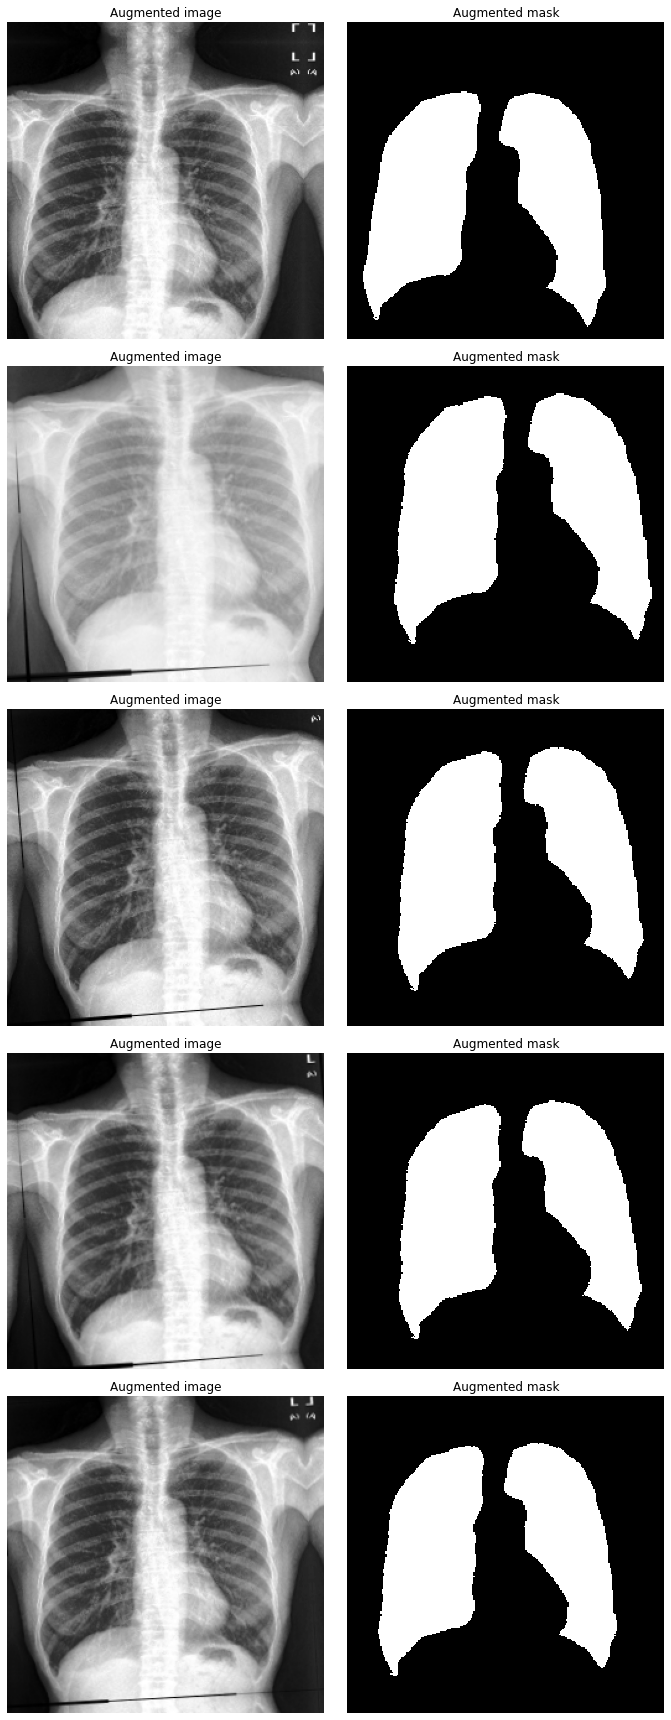

In [ ]:
random.seed()
visualise_train_data = SegmentationData(inputs_train, mask_train, True, transform=train_transform) #train_data za vizuelizaciju
visualize_augmentations(visualise_train_data, idx=123)

##Defining functions and parameters for training

In [ ]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    return ce_loss


In [ ]:
def UnetAccuracy(preds, targets):
    metric = BinaryJaccardIndex().to(device)
    return metric(preds, targets)

###Defining function for combining UNet outputs

In [ ]:
#UNet has 2 outputs on the final layer, so we decided that the best solution is to combine those two outputs and create one that represents mask

def combine_outputs(outputs):
    list_of_tensors = []
    for pred_mask in outputs:
        pred_mask = pred_mask.permute(1,2,0).cpu().detach().numpy()
        firstChannelMask = pred_mask[:,:,0]
        firstChannelMask[firstChannelMask <= firstChannelMask.mean()] = 0
        firstChannelMask[firstChannelMask > firstChannelMask.mean()] = 1

        secondChannelMask = pred_mask[:,:,1]
        secondChannelMask[secondChannelMask <= secondChannelMask.mean()] = 0
        secondChannelMask[secondChannelMask > secondChannelMask.mean()] = 1

        mask_pred = 1 - (firstChannelMask - secondChannelMask)
        threshold = mask_pred.mean()

        mask_pred[mask_pred <= threshold] = 0
        mask_pred[mask_pred > threshold] =1
        mask_pred.astype(np.int8)

        list_of_tensors.append(torch.from_numpy(mask_pred))

    return torch.stack(list_of_tensors)

###Training function

In [ ]:
def train(model, trainloader, optimizer, criterion, accuracy_func):
    model = model.to(device)
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    acc_total = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, masks = data
        #plt.figure(figsize=(12,12))
        #print(np.unique(image[i]))
        # cv2_imshow(image[0].permute(2,1,0))
        image = image.to(device)
        # cv2_imshow(masks[0].permute(2,1,0))
        #print(np.unique(masks[i]))
        masks = masks.to(device)

        #optimizer = optimizer.to(device)
        # Forward pass.
        outputs = model(image)
        optimizer.zero_grad()

        # Calculate the loss.
        loss = criterion(outputs, masks.long()) # Calculate cross entropy loss

        loss.backward() # Backpropogate loss
        optimizer.step() # Apply gradient descent change to weight
        train_running_loss += loss.item()

        outputs_combined = combine_outputs(outputs)
        outputs_combined = outputs_combined.to(device)
        acc = accuracy_func(outputs_combined, masks.long())
        acc_total += acc

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    acc_avg = acc_total / counter
    return epoch_loss, acc_avg

###Validation *function*

In [ ]:
def validate(model, testloader, criterion, accuracy_func):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    acc_total = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, masks = data
            image = image.to(device)
            masks = masks.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, masks.long())
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            outputs_combined = combine_outputs(outputs)
            outputs_combined = outputs_combined.to(device)
            acc = accuracy_func(outputs_combined, masks.long())
            acc_total += acc

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc_avg = acc_total / counter

    return epoch_loss, epoch_acc_avg

###Parameters, loss and optimizer

In [ ]:
model = UNet()
train_data_loader = DataLoader(train_data, batch_size=32, num_workers = 2, shuffle=True)
val_data_loader = DataLoader(valid_data, batch_size=32, num_workers = 2, shuffle=False)
learning_rate = 0.0001
epochs = 40
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = UnetLoss
accuracy_func = UnetAccuracy

###Load saved model

In [ ]:
#path = '/content/MyDrive/MyDrive/lung_segmentation_model/lung_model_pretrained_True_epochs_{epochs}.pth' #just change number of epochs
#model.load_state_dict(torch.load(path)['model_state_dict'])
#model.eval()

In [ ]:
PATH_model = '/content/MyDrive/MyDrive/kaggle_dataset/Model_za_profu/model_120_epochs_(actually101)_.pth'
model.load_state_dict(torch.load(PATH_model))


<All keys matched successfully>

In [ ]:
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, k

##Training

In [ ]:
#train_loss, valid_loss = [], []

train_loss = []
valid_loss = []

train_acc = []
valid_acc = []


patience = 20
best_model = model
last_val_epoch_loss = 1000
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, acc = train(model, train_data_loader, optimizer,
                                  criterion, accuracy_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_data_loader,
                                                criterion, accuracy_func)

    #we could go with valid_epoch_loss and acc
    if last_val_epoch_loss <= valid_epoch_loss:
        trigger_times += 1
        print('Trigger Times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            break

    else:
        best_model = model
        print('trigger times: 0')
        print('Model is saved')
        #save_model(epoch, best_model, optimizer, criterion, True)
        trigger_times = 0

        last_val_epoch_loss = valid_epoch_loss
    time.sleep(3)

    # Save the trained model weights.
    #save_model(epoch, best_model, optimizer, criterion, True)

    #train_loss.append(train_epoch_loss)

    print(f"Training loss: {train_epoch_loss:.3f}")
    print(f"Train Acc: {acc:.3f}")
    print('-'*50)

    print(f"Valid loss: {valid_epoch_loss:.3f}")
    print(f"Val Acc: {valid_epoch_acc:.3f}")
    print('-'*50)


    #appending values for chart

    train_loss.append(train_epoch_loss)
    train_acc.append(acc.to('cpu'))

    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc.to('cpu'))


    time.sleep(1)

[INFO]: Epoch 1 of 40
Training


100%|██████████| 18/18 [01:43<00:00,  5.76s/it]

Validation



100%|██████████| 5/5 [00:35<00:00,  7.05s/it]


trigger times: 0
Model is saved
Training loss: 0.038
Train Acc: 0.936
--------------------------------------------------
Valid loss: 0.050
Val Acc: 0.937
--------------------------------------------------
[INFO]: Epoch 2 of 40
Training


100%|██████████| 18/18 [01:44<00:00,  5.82s/it]

Validation



100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


trigger times: 0
Model is saved
Training loss: 0.037
Train Acc: 0.938
--------------------------------------------------
Valid loss: 0.050
Val Acc: 0.927
--------------------------------------------------
[INFO]: Epoch 3 of 40
Training


100%|██████████| 18/18 [01:43<00:00,  5.73s/it]

Validation



100%|██████████| 5/5 [00:37<00:00,  7.44s/it]


trigger times: 0
Model is saved
Training loss: 0.035
Train Acc: 0.940
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.935
--------------------------------------------------
[INFO]: Epoch 4 of 40
Training


100%|██████████| 18/18 [01:44<00:00,  5.80s/it]

Validation



100%|██████████| 5/5 [00:34<00:00,  6.96s/it]


Trigger Times: 1
Training loss: 0.035
Train Acc: 0.940
--------------------------------------------------
Valid loss: 0.053
Val Acc: 0.921
--------------------------------------------------
[INFO]: Epoch 5 of 40
Training


100%|██████████| 18/18 [01:44<00:00,  5.81s/it]

Validation



100%|██████████| 5/5 [00:34<00:00,  6.81s/it]


Trigger Times: 2
Training loss: 0.034
Train Acc: 0.941
--------------------------------------------------
Valid loss: 0.048
Val Acc: 0.937
--------------------------------------------------
[INFO]: Epoch 6 of 40
Training


100%|██████████| 18/18 [01:44<00:00,  5.79s/it]

Validation



100%|██████████| 5/5 [00:33<00:00,  6.63s/it]


Trigger Times: 3
Training loss: 0.034
Train Acc: 0.942
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.934
--------------------------------------------------
[INFO]: Epoch 7 of 40
Training


100%|██████████| 18/18 [01:43<00:00,  5.75s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


Trigger Times: 4
Training loss: 0.034
Train Acc: 0.940
--------------------------------------------------
Valid loss: 0.048
Val Acc: 0.934
--------------------------------------------------
[INFO]: Epoch 8 of 40
Training


100%|██████████| 18/18 [01:42<00:00,  5.68s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.57s/it]


Trigger Times: 5
Training loss: 0.034
Train Acc: 0.940
--------------------------------------------------
Valid loss: 0.051
Val Acc: 0.923
--------------------------------------------------
[INFO]: Epoch 9 of 40
Training


100%|██████████| 18/18 [01:41<00:00,  5.64s/it]

Validation



100%|██████████| 5/5 [00:34<00:00,  6.84s/it]


trigger times: 0
Model is saved
Training loss: 0.033
Train Acc: 0.937
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.931
--------------------------------------------------
[INFO]: Epoch 10 of 40
Training


100%|██████████| 18/18 [01:44<00:00,  5.80s/it]

Validation



100%|██████████| 5/5 [00:33<00:00,  6.68s/it]


Trigger Times: 1
Training loss: 0.033
Train Acc: 0.940
--------------------------------------------------
Valid loss: 0.050
Val Acc: 0.934
--------------------------------------------------
[INFO]: Epoch 11 of 40
Training


100%|██████████| 18/18 [01:40<00:00,  5.58s/it]

Validation



100%|██████████| 5/5 [00:33<00:00,  6.64s/it]


trigger times: 0
Model is saved
Training loss: 0.033
Train Acc: 0.940
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.935
--------------------------------------------------
[INFO]: Epoch 12 of 40
Training


100%|██████████| 18/18 [01:40<00:00,  5.60s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.52s/it]


Trigger Times: 1
Training loss: 0.031
Train Acc: 0.945
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.938
--------------------------------------------------
[INFO]: Epoch 13 of 40
Training


100%|██████████| 18/18 [01:39<00:00,  5.52s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


Trigger Times: 2
Training loss: 0.030
Train Acc: 0.946
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.934
--------------------------------------------------
[INFO]: Epoch 14 of 40
Training


100%|██████████| 18/18 [01:38<00:00,  5.50s/it]

Validation



100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


Trigger Times: 3
Training loss: 0.030
Train Acc: 0.944
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.939
--------------------------------------------------
[INFO]: Epoch 15 of 40
Training


100%|██████████| 18/18 [01:38<00:00,  5.48s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.45s/it]


Trigger Times: 4
Training loss: 0.032
Train Acc: 0.942
--------------------------------------------------
Valid loss: 0.051
Val Acc: 0.924
--------------------------------------------------
[INFO]: Epoch 16 of 40
Training


100%|██████████| 18/18 [01:38<00:00,  5.45s/it]

Validation



100%|██████████| 5/5 [00:34<00:00,  6.86s/it]


Trigger Times: 5
Training loss: 0.032
Train Acc: 0.941
--------------------------------------------------
Valid loss: 0.048
Val Acc: 0.937
--------------------------------------------------
[INFO]: Epoch 17 of 40
Training


100%|██████████| 18/18 [01:38<00:00,  5.45s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


Trigger Times: 6
Training loss: 0.033
Train Acc: 0.941
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.929
--------------------------------------------------
[INFO]: Epoch 18 of 40
Training


100%|██████████| 18/18 [01:37<00:00,  5.40s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.58s/it]


Trigger Times: 7
Training loss: 0.031
Train Acc: 0.942
--------------------------------------------------
Valid loss: 0.049
Val Acc: 0.937
--------------------------------------------------
[INFO]: Epoch 19 of 40
Training


100%|██████████| 18/18 [01:38<00:00,  5.45s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


Trigger Times: 8
Training loss: 0.031
Train Acc: 0.945
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.935
--------------------------------------------------
[INFO]: Epoch 20 of 40
Training


100%|██████████| 18/18 [01:37<00:00,  5.43s/it]

Validation



100%|██████████| 5/5 [00:31<00:00,  6.38s/it]


Trigger Times: 9
Training loss: 0.030
Train Acc: 0.944
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.939
--------------------------------------------------
[INFO]: Epoch 21 of 40
Training


100%|██████████| 18/18 [01:37<00:00,  5.44s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


Trigger Times: 10
Training loss: 0.030
Train Acc: 0.944
--------------------------------------------------
Valid loss: 0.050
Val Acc: 0.931
--------------------------------------------------
[INFO]: Epoch 22 of 40
Training


100%|██████████| 18/18 [01:36<00:00,  5.34s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.43s/it]


Trigger Times: 11
Training loss: 0.029
Train Acc: 0.946
--------------------------------------------------
Valid loss: 0.049
Val Acc: 0.933
--------------------------------------------------
[INFO]: Epoch 23 of 40
Training


100%|██████████| 18/18 [01:37<00:00,  5.42s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


Trigger Times: 12
Training loss: 0.029
Train Acc: 0.942
--------------------------------------------------
Valid loss: 0.049
Val Acc: 0.935
--------------------------------------------------
[INFO]: Epoch 24 of 40
Training


100%|██████████| 18/18 [01:36<00:00,  5.34s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.45s/it]


Trigger Times: 13
Training loss: 0.029
Train Acc: 0.947
--------------------------------------------------
Valid loss: 0.047
Val Acc: 0.935
--------------------------------------------------
[INFO]: Epoch 25 of 40
Training


100%|██████████| 18/18 [01:38<00:00,  5.46s/it]

Validation



100%|██████████| 5/5 [00:33<00:00,  6.67s/it]


Trigger Times: 14
Training loss: 0.028
Train Acc: 0.948
--------------------------------------------------
Valid loss: 0.050
Val Acc: 0.932
--------------------------------------------------
[INFO]: Epoch 26 of 40
Training


100%|██████████| 18/18 [01:37<00:00,  5.40s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


Trigger Times: 15
Training loss: 0.028
Train Acc: 0.948
--------------------------------------------------
Valid loss: 0.048
Val Acc: 0.936
--------------------------------------------------
[INFO]: Epoch 27 of 40
Training


100%|██████████| 18/18 [01:37<00:00,  5.40s/it]

Validation



100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


Trigger Times: 16
Training loss: 0.029
Train Acc: 0.939
--------------------------------------------------
Valid loss: 0.051
Val Acc: 0.935
--------------------------------------------------
[INFO]: Epoch 28 of 40
Training


100%|██████████| 18/18 [01:36<00:00,  5.37s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


Trigger Times: 17
Training loss: 0.028
Train Acc: 0.947
--------------------------------------------------
Valid loss: 0.048
Val Acc: 0.937
--------------------------------------------------
[INFO]: Epoch 29 of 40
Training


100%|██████████| 18/18 [01:36<00:00,  5.35s/it]

Validation



100%|██████████| 5/5 [00:33<00:00,  6.75s/it]


Trigger Times: 18
Training loss: 0.027
Train Acc: 0.948
--------------------------------------------------
Valid loss: 0.050
Val Acc: 0.940
--------------------------------------------------
[INFO]: Epoch 30 of 40
Training


100%|██████████| 18/18 [01:36<00:00,  5.36s/it]

Validation



100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


Trigger Times: 19
Training loss: 0.027
Train Acc: 0.950
--------------------------------------------------
Valid loss: 0.051
Val Acc: 0.927
--------------------------------------------------
[INFO]: Epoch 31 of 40
Training


100%|██████████| 18/18 [01:35<00:00,  5.33s/it]

Validation



100%|██████████| 5/5 [00:33<00:00,  6.79s/it]

Trigger Times: 20
Early stopping!
Start to test process.


In [ ]:
print('train_loss=',train_loss)
print('valid_loss=',valid_loss)
print('train_acc=',train_acc)
print('valid_acc=',valid_acc)

train_loss= [0.03797694109380245, 0.03709351292086972, 0.03534580932723151, 0.035151137970387936, 0.034212877559993, 0.03358967064155473, 0.03399519922418727, 0.03387828833527035, 0.033101174566480845, 0.03283517931898435, 0.03333467421018415, 0.03075048244661755, 0.030434479005634785, 0.030086505537231762, 0.03234962270491653, 0.032453053527408175, 0.032508117250270314, 0.03064341687907775, 0.03051980636599991, 0.03048624988231394, 0.030223189025289483, 0.028991689595083397, 0.029253499789370432, 0.028843928852842912, 0.028398502204153273, 0.028274751061366662, 0.02927056410246425, 0.028177616600361135, 0.02735600568768051, 0.027158347682820425]
valid_loss= [0.04989444315433502, 0.049759294092655185, 0.047017105668783185, 0.05296503007411957, 0.048290617763996124, 0.047390232980251315, 0.047725672274827956, 0.05100225731730461, 0.046611031889915465, 0.05016178637742996, 0.04656839966773987, 0.04716864675283432, 0.047084685415029526, 0.04726506471633911, 0.050688160210847856, 0.0480535

In [ ]:
PATH_model = '/content/MyDrive/MyDrive/kaggle_dataset/Model_za_profu/model_120_epochs_(actually101)_.pth'

torch.save(best_model.state_dict(), PATH_model)

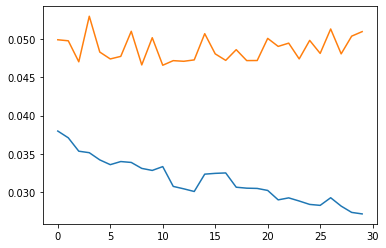

In [ ]:
import matplotlib.pyplot as plt

y = train_loss
z = valid_loss
x = np.arange(len(y))

plt.plot(x,y,z)

In [ ]:
train_acc_np = []
val_acc_np = []
for i in range(len(train_acc)):
  train_acc_np.append(train_acc[i].numpy())
  print(train_acc[i].numpy())
  val_acc_np.append(valid_acc[i].numpy())

0.93627
0.9378436
0.9396305
0.939794
0.940608
0.94211334
0.939708
0.9399775
0.93731195
0.9400673
0.940449
0.94456124
0.9457972
0.9441466
0.9421338
0.941188
0.9407084
0.94242054
0.94537437
0.94364345
0.944129
0.94567627
0.9418719
0.9467976
0.9479437
0.9482226
0.9387453
0.94720155
0.9483226
0.94999546


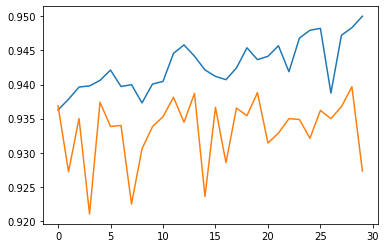

In [ ]:
plt.plot(x, train_acc_np, val_acc_np)

#Creating dict for plotting

In [ ]:
dict_plot = []

dict_plot.append(
    {
        "train_loss":train_loss,
        'valid_loss':valid_loss,
        'train_acc':train_acc_np,
        'valid_acc':val_acc_np
    }
)

### Take into account all of the iterations

In [ ]:
import pandas as pd

df = pd.DataFrame(dict_plot)
df.to_csv('/content/MyDrive/MyDrive/dict2.csv')

In [ ]:
data = pd.read_csv('/content/dict1.csv')

In [ ]:
train_loss = data['train_loss']
train_acc = data['train_acc']
valid_loss = data['valid_loss']
valid_acc = data['valid_acc']

In [ ]:
train_loss_arr = np.zeros(110)
valid_loss_arr = np.zeros(110)

In [ ]:
print(len(train_loss[0].split(',')))

for i in range(len(train_loss_arr)):
  if (i==0):
    train_loss_arr[i]=train_loss[0].split(',')[i].split('[')[-1]
    valid_loss_arr[i]=valid_loss[0].split(',')[i].split('[')[-1]
  elif(i==109):
    train_loss_arr[i]=train_loss[0].split(',')[i].split(']')[0]
    valid_loss_arr[i]=valid_loss[0].split(',')[i].split(']')[0]

  else:
    train_loss_arr[i]=train_loss[0].split(',')[i]
    valid_loss_arr[i]=valid_loss[0].split(',')[i]

110


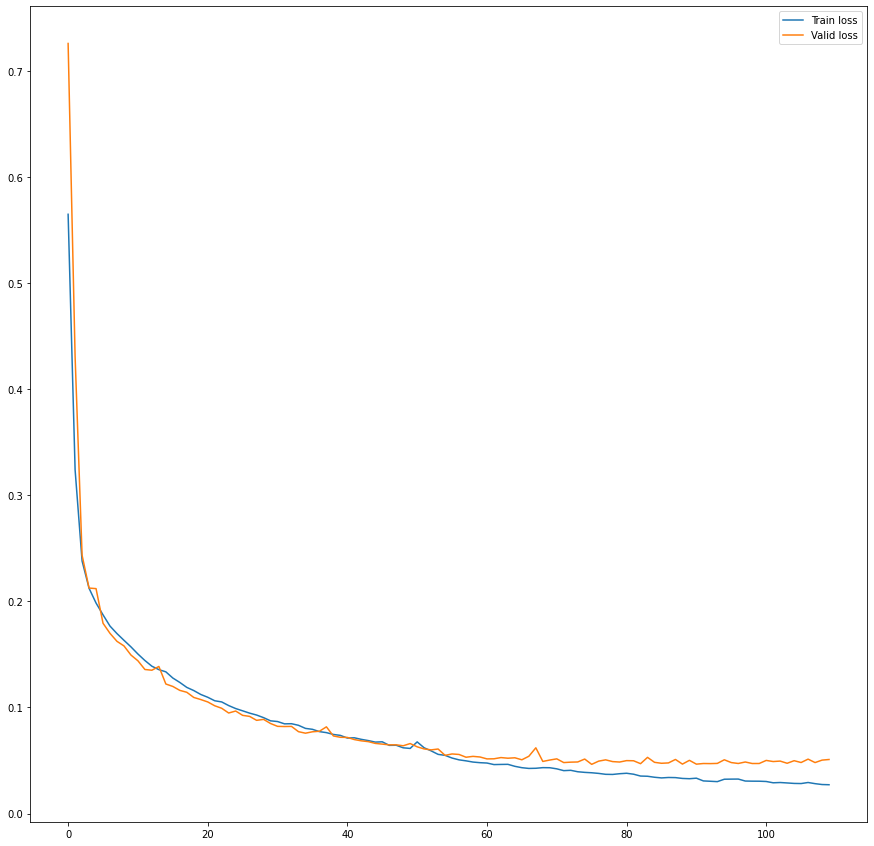

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(np.arange(110), train_loss_arr, valid_loss_arr)
plt.legend(['Train loss','Valid loss'])

In [ ]:
train_acc_arr = np.zeros(110)
valid_acc_arr = np.zeros(110)
print(len(train_acc[0].split(',')))
k = 0
for i in range(0,len(valid_acc[0].split(',')),2):

  train_acc_arr[int(i/2)] = train_acc[0].split(',')[i].split('array(')[-1]
  valid_acc_arr[int(i/2)] = valid_acc[0].split(',')[i].split('array(')[-1]



220


In [ ]:
print(train_acc_arr)
print(valid_acc_arr)

[0.33480626 0.49422064 0.5524232  0.5938837  0.6140855  0.6530245
 0.6817873  0.70920235 0.74619603 0.7554603  0.78474605 0.8065165
 0.8281519  0.8383819  0.8490656  0.860815   0.8715976  0.8825737
 0.88956535 0.89475834 0.8980725  0.89818585 0.90237933 0.90338284
 0.91050553 0.9106978  0.9121565  0.9134471  0.91550523 0.9144121
 0.9192555  0.918528   0.9164915  0.9177706  0.92060894 0.9201607
 0.9204554  0.91883194 0.92272377 0.9223705  0.92536926 0.91796356
 0.9183373  0.9239619  0.92488027 0.9250924  0.926146   0.92959934
 0.9281412  0.9290493  0.9143107  0.9229916  0.9213912  0.92818
 0.9290694  0.9326631  0.9335097  0.92866975 0.9293946  0.93301934
 0.93289167 0.93398327 0.9321827  0.93196064 0.9334844  0.930527
 0.9310662  0.92947334 0.9286269  0.927237   0.92910224 0.9317778
 0.9355206  0.9367766  0.9377701  0.93313247 0.93948907 0.9397992
 0.9395545  0.93296707 0.93627    0.9378436  0.9396305  0.939794
 0.940608   0.94211334 0.939708   0.9399775  0.93731195 0.9400673
 0.940449 

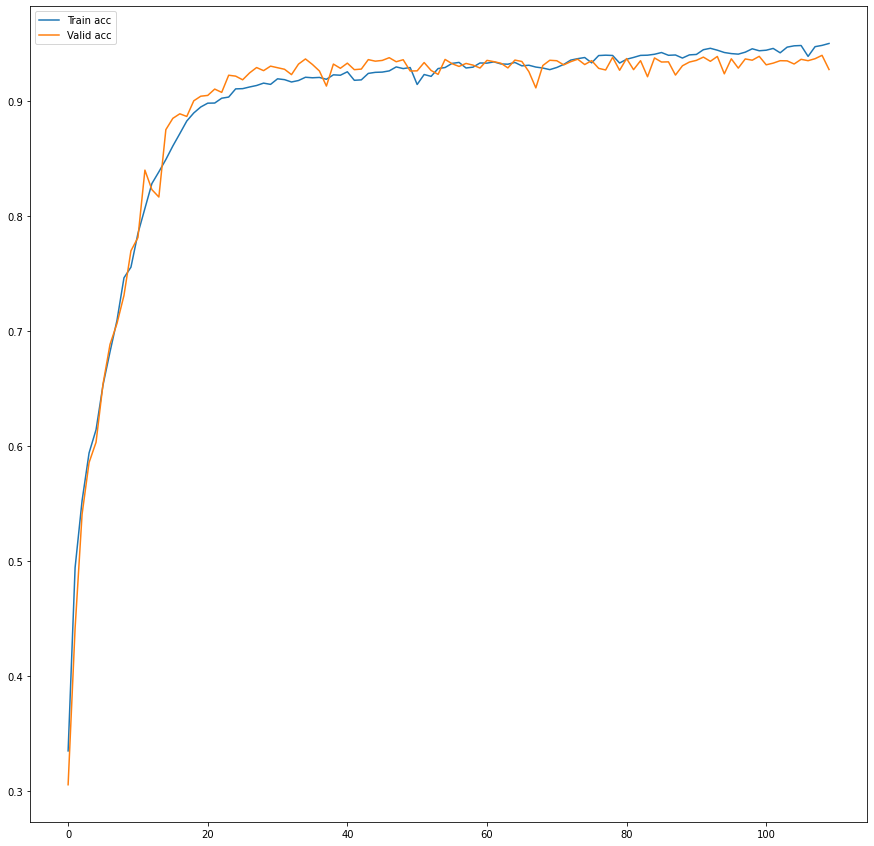

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(np.arange(110),train_acc_arr,valid_acc_arr)
plt.legend(['Train acc','Valid acc'])


In [ ]:
PATH_model = '/content/MyDrive/MyDrive/kaggle_dataset/Model_za_profu/model_120_epochs_(actually101)_.pth'
model.load_state_dict(torch.load(PATH_model))
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, k

#Testing the reults

In [ ]:
model.to(device)

In [ ]:
size = 256

img = cv2.imread('/content/MyDrive/MyDrive/kaggle_dataset/lung_segmentation/data/Lung Segmentation/test/CHNCXR_0186_0.png') # test
img = cv2.resize(img, (size, size), interpolation = cv2.INTER_NEAREST)[:,:,0] / img.max()
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor[None, :]
img_tensor = img_tensor[None, :]
img_tensor = img_tensor.float()
img_tensor = img_tensor.to(device)
#mask = cv2.imread(mask_path +'/CHNCXR_0254_1.png')
"""
print(img.shape)
print(mask.shape)

#plt.imshow(img, cmap='gray')
#plt.imshow(mask,cmap='gray')

#plt.figure(figsize=(10,10))
#plt.imshow(np.concatenate((img,mask),axis=1))
#plt.title('Real image')


img = cv2.resize(img, (size, size), interpolation = cv2.INTER_NEAREST)[:,:,0] / img.max()
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor[None, :]
img_tensor = img_tensor[None, :]
img_tensor = img_tensor.float()
img_tensor = img_tensor.to(device)

mask = cv2.resize(mask, (size, size), interpolation = cv2.INTER_NEAREST)[:,:,0] / mask.max()
mask_tensor = torch.from_numpy(mask)
mask_tensor = mask_tensor[None, :]
mask_tensor = mask_tensor[None, :]
mask_tensor = mask_tensor.float()

plt.figure(figsize=(10,10))
plt.imshow(np.concatenate((img,mask),axis=1),cmap='gray')
plt.title('Real image')

"""

"\nprint(img.shape)\nprint(mask.shape)\n\n#plt.imshow(img, cmap='gray')\n#plt.imshow(mask,cmap='gray')\n\n#plt.figure(figsize=(10,10))\n#plt.imshow(np.concatenate((img,mask),axis=1))\n#plt.title('Real image')\n\n\nimg = cv2.resize(img, (size, size), interpolation = cv2.INTER_NEAREST)[:,:,0] / img.max()\nimg_tensor = torch.from_numpy(img)\nimg_tensor = img_tensor[None, :]\nimg_tensor = img_tensor[None, :]\nimg_tensor = img_tensor.float()\nimg_tensor = img_tensor.to(device)\n\nmask = cv2.resize(mask, (size, size), interpolation = cv2.INTER_NEAREST)[:,:,0] / mask.max()\nmask_tensor = torch.from_numpy(mask)\nmask_tensor = mask_tensor[None, :]\nmask_tensor = mask_tensor[None, :]\nmask_tensor = mask_tensor.float()\n\nplt.figure(figsize=(10,10))\nplt.imshow(np.concatenate((img,mask),axis=1),cmap='gray')\nplt.title('Real image')\n\n"

Text(0.5, 1.0, 'Model predicted on image from test set')

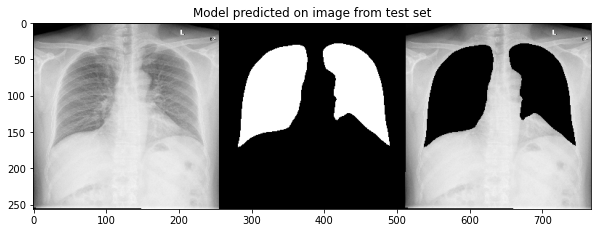

In [ ]:
model_mask = combine_outputs(model(img_tensor))

mask_to_show = model_mask.permute(1,2,0).cpu().detach().numpy()

plt.figure(figsize=(10,10))
#plt.legend(['Model predicted'])
plt.imshow(np.concatenate((img,mask_to_show[:,:,0], img-img*mask_to_show[:,:,0]),axis=1), cmap='gray')
plt.title('Model predicted on image from test set')

##Checking the results

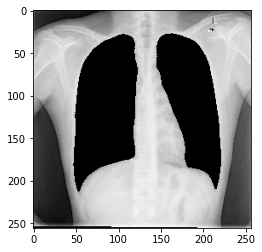

In [ ]:
plt.imshow(img-mask_to_show[:,:,0]*img,cmap='gray')

In [ ]:
size = 256

img = cv2.imread('/content/MyDrive/MyDrive/kaggle_dataset/lung_segmentation/data/Lung Segmentation/test/CHNCXR_0489_1.png') # test
mask = cv2.imread(mask_path +'/CHNCXR_0051_0_mask.png')

img_with_mask = np.concatenate((img, mask), axis=1)
plt.imshow(img_with_mask, cmap='gray')

img = cv2.resize(img, (size, size), interpolation = cv2.INTER_NEAREST)[:,:,0] / img.max()
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor[None, :]
img_tensor = img_tensor[None, :]
img_tensor = img_tensor.float()
img_tensor = img_tensor.to(device)

mask = cv2.resize(mask, (size, size), interpolation = cv2.INTER_NEAREST)[:,:,0] / mask.max()
mask_tensor = torch.from_numpy(mask)
mask_tensor = mask_tensor[None, :]
mask_tensor = mask_tensor[None, :]
mask_tensor = mask_tensor.float()